# Couch-Potato Movie Recommendation System

# Business Understanding

## 1. Project Objective

Our team is building a movie recommendation system using the MovieLens dataset (100,000 user ratings) to provide personalized movie suggestions. The primary goal is to recommend the top 5 movies a user is most likely to enjoy based on their historical rating patterns.

## 2. Problem Statement

Users often struggle to discover movies that match their preferences when faced with large movie catalogs. Without personalized recommendations, users may:
- Spend excessive time browsing without finding suitable content
- Miss movies they would enjoy
- Experience decision fatigue leading to reduced engagement

Our recommendation system addresses this by analyzing user rating patterns to surface movies that align with their tastes.

## 3. Technical Approach

We will implement **Collaborative Filtering (CF)** as our core recommendation methodology. Collaborative filtering works by identifying users with similar movie preferences and recommending movies that similar users have enjoyed.

**How it works:**
- When a user rates movies, the system finds other users with similar rating patterns
- The system identifies movies that similar users rated highly but our target user hasn't seen
- These movies become our recommendations

**Input**: User's existing movie ratings  
**Output**: Top 5 personalized movie recommendations

## 4. Key Challenges

**Sparse Data**: Most users rate only a small fraction of available movies, making it harder to find similar users and identify patterns.

**Cold Start Problem**: Users with few ratings are particularly challenging for collaborative filtering, which relies on having enough rating history to find meaningful similarities with other users. We need to ensure our system can provide reasonable recommendations even for users with limited rating history.

## 5. Success Metrics

We will evaluate our recommendation system using multiple metrics:

- **RMSE (Root Mean Squared Error)**: Measures how accurately we can predict what rating a user would give to recommended movies
  - *Target*: RMSE < 1.0 (within 1 star of actual rating)
  
- **Precision@5**: What proportion of our top 5 recommendations are actually good matches that users would rate highly

- **Coverage**: Percentage of users for whom we can generate meaningful recommendations

- **User Segment Performance**: Evaluate how well the system performs for users with different amounts of rating history (e.g., 5 ratings vs 50+ ratings)

## 6. Expected Outcomes

By implementing collaborative filtering, we aim to deliver a recommendation system that helps users discover movies they'll enjoy, reducing search time and improving their overall experience with the movie catalog.

# Data Understanding

In [20]:
# import relevant libraries
import pandas as pd
import numpy as np

#visualization libraries
import seaborn as sns

## 1. Links Dataset

In [3]:
links_df = pd.read_csv("Data/links.csv")
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


### Dataset Description
* `movieId` is an identifier for movies used by [MovieLens](https://movielens.org). 
* `imdbId` is an identifier for movies used by [IMDb](http://www.imdb.com).
* `tmdbId` is an identifier for movies used by [TMDb](https://www.themoviedb.org).

In [10]:
#check the first 5 rows
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [11]:
#check the last 5 rows
links_df.tail()

,movieId,imdbId,tmdbId
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0
9741,193609,101726,37891.0


The dataset is uniform from start to finish.

In [5]:
#check shape
print(f"The links dataset has {links_df.shape[0]} rows and {links_df.shape[1]} columns.")

The links dataset has 9742 rows and 3 columns.


In [6]:
#get metadata
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


**Observation**

The links dataset has 3 columns of numerical data type and 8 nulls in the tmdbId column.

In [7]:
#check statistical summary
links_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9742.0,42200.353623,5.216049e+04,1.0,3248.25,7300.0,76232.00,193609.0
imdbId,9742.0,677183.898173,1.107228e+06,417.0,95180.75,167260.5,805568.50,8391976.0
tmdbId,9734.0,55162.123793,9.365348e+04,2.0,9665.50,16529.0,44205.75,525662.0


In [26]:
#check nulls
print(f" The links dataset has {links_df.isna().sum().sum()} null values.")

 The links dataset has 8 null values.


In [23]:
#check duplicates
print(f"The links dataset has {links_df.duplicated().sum()} duplicates.")

The links dataset has 0 duplicates.


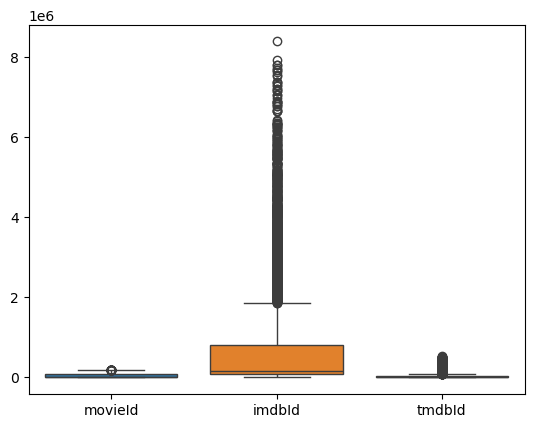

In [22]:
#check for outliers
sns.boxplot(links_df);

**Observation**

The links dataset seems to have many outliers in the `imdbId` column but they are genuine outliers; so we will keep them.

## 2. Movies Dataset

In [27]:
#load and read dataset
movies_df = pd.read_csv("Data/movies.csv")
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


### Dataset Description  

1. `title` is the name of a film and includes the year of release in parentheses.

2. These are the `genres` present in the dataset:

* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western

In [28]:
#check the first 5 rows
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
#check the last 5 rows
movies_df.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


**Observation**

The movies dataset is uniform from start to finish.

In [30]:
#get metadata
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Observation**

The movies dataset has one numerical column and 2 categorical columns.

In [44]:
#check shape
print(f"The movies dataset has {movies_df.shape[0]} rows and {movies_df.shape[1]} columns.")

The movies dataset has 9742 rows and 3 columns.


In [31]:
#statistical summary of the numerical column
movies_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,9742.0,42200.353623,52160.494854,1.0,3248.25,7300.0,76232.0,193609.0


In [32]:
#statistical summary of the categorical columns
movies_df.describe(include="object").T

,count,unique,top,freq
title,9742,9737,Saturn 3 (1980),2
genres,9742,951,Drama,1053


In [33]:
#check nulls
print(f" The movies dataset has {movies_df.isna().sum().sum()} null values.")

 The movies dataset has 0 null values.


In [34]:
#check duplicates
print(f"The movies dataset has {movies_df.duplicated().sum()} duplicates.")

The movies dataset has 0 duplicates.


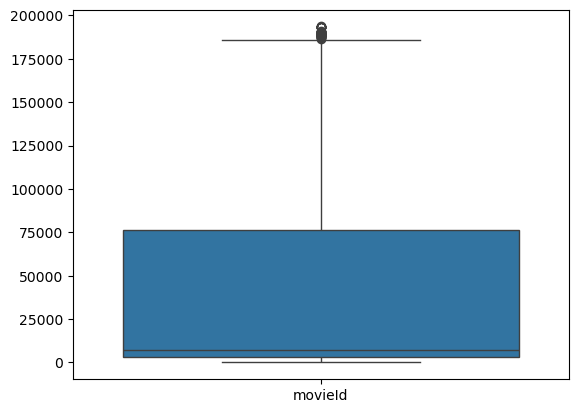

In [36]:
#check for outliers
sns.boxplot(movies_df);

**Observation**

The movies dataset has no outliers.

## 3. Ratings Dataset

In [38]:
#load and read dataset
ratings_df = pd.read_csv("Data/ratings.csv")
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Dataset Description  

* Each row represents one rating of one movie by one user.

* `rating` are made on a 5-star scale with half-star increments (0.5 stars - 5.0 stars).

* `timestamp` represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [39]:
#check the first 5 rows
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [40]:
#check the last rows
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


**Observation**

The ratings dataset is uniform from start to finish.

In [45]:
#check shape
print(f"The ratings dataset has {ratings_df.shape[0]} rows and {ratings_df.shape[1]} columns.")

The ratings dataset has 100836 rows and 4 columns.


In [ ]:
#get metadata

ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**Observation**

The dataset has 4 numerical columns.

In [42]:
#statistical summary of the numerical columns
ratings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,3.261276e+02,1.826185e+02,1.0,1.770000e+02,3.250000e+02,4.770000e+02,6.100000e+02
movieId,100836.0,1.943530e+04,3.553099e+04,1.0,1.199000e+03,2.991000e+03,8.122000e+03,1.936090e+05
rating,100836.0,3.501557e+00,1.042529e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,100836.0,1.205946e+09,2.162610e+08,828124615.0,1.019124e+09,1.186087e+09,1.435994e+09,1.537799e+09


In [47]:
#check nulls
print(f"The ratings dataset has {ratings_df.isna().sum().sum()} null values.")

The ratings dataset has 0 null values.


In [46]:
#check duplicates
print(f"The ratings dataset has {ratings_df.duplicated().sum()} duplicates.")

The ratings dataset has 0 duplicates.


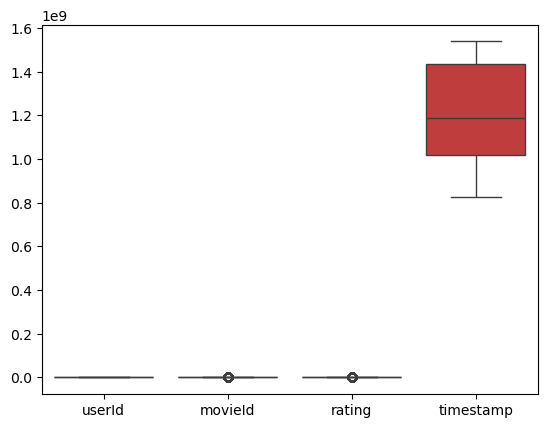

In [48]:
#check for outliers
sns.boxplot(ratings_df);

**Observation**

The ratings dataset has no outliers.

## 4. Tags Dataset


In [49]:
#load and read dataset
tags_df = pd.read_csv("Data/tags.csv")
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


### Dataset Description

* Tags are user-generated metadata about movies. Each `tag` is typically a single word or short phrase. The meaning, value and purpose of a particular tag is determined by each user.

* `timestamp` represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

In [52]:
#check the first 5 rows
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [53]:
#check the last 5 rows
tags_df.tail()

,userId,movieId,tag,timestamp
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978
3682,610,168248,Heroic Bloodshed,1493844270


**Observation**

The tags dataset is uniform from start to finish.

In [51]:
#check shape
print(f"The tags dataset has {tags_df.shape[0]} rows and {tags_df.shape[1]} columns.")

The tags dataset has 3683 rows and 4 columns.


In [ ]:
#get metadata
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


**Observation**

The tags dataset has one categorical columns and 3 numerical columns.

In [55]:
#statistical summary of numerical columns
tags_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,3683.0,4.311493e+02,1.584726e+02,2.000000e+00,4.240000e+02,4.740000e+02,4.770000e+02,6.100000e+02
movieId,3683.0,2.725201e+04,4.349056e+04,1.000000e+00,1.262500e+03,4.454000e+03,3.926300e+04,1.935650e+05
timestamp,3683.0,1.320032e+09,1.721025e+08,1.137179e+09,1.137521e+09,1.269833e+09,1.498457e+09,1.537099e+09


In [56]:
#statistical summary of the categorical column
tags_df.describe(include="object").T

,count,unique,top,freq
tag,3683,1589,In Netflix queue,131


In [57]:
#check for nulls
print(f"The tags dataset has {tags_df.isna().sum().sum()} null values.")

The tags dataset has 0 null values.


In [58]:
#check for duplicates
print(f"The tags dataset has {tags_df.duplicated().sum()} duplicates.")

The tags dataset has 0 duplicates.


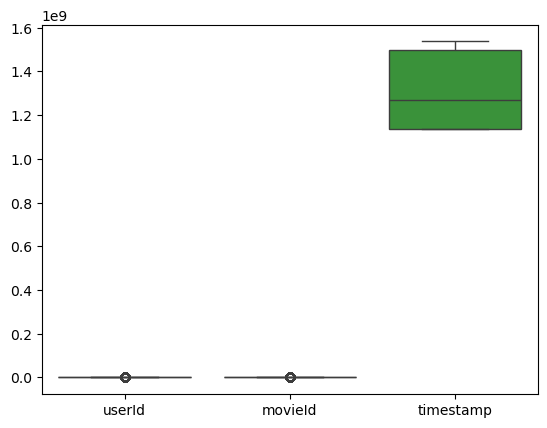

In [60]:
#check for outliers
sns.boxplot(tags_df);

**Observation**

The tags dataset has no outliers.